# Scraping Candle Data from Etsy
#### Friday, July 7, 2023
#### Rebecca Neel

The purpose of this notebook is to scrape candle data from Etsy in order to build a [pricing model](<mark>link to modeling notebook</mark>) to help you price the candle(s) you wish to sell on Etsy.

## Data Source

Data is being scraped from the [Home & Living >> Home Decor >> Candles & Holders >> Candles](https://www.etsy.com/c/home-and-living/home-decor/candles-and-holders/candles?explicit=1&ref=catcard-2791-264940576) section of Etsy.

At the time of this scraping, there were approximately 428,054 results available, including ads, sorted in order of "relevancy".

**Date of scraping: July 7, 2023 - July 10, 2023**

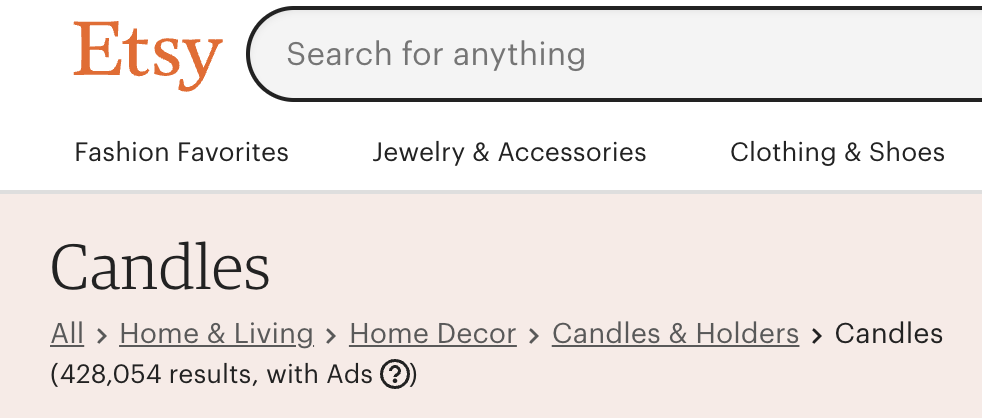

It is not clear how "relevancy" is calculated or determined by Etsy, but I chose to leave items ordered by "Relevancy" and scrape the first 4080 pages of results. The number of pages I decided to scrape was determined by my personal deadline to move on to the next phase of this project (in about 68 hours) and the fact that scraping 1 page of results takes about 1 minute.

When the data is scraped, I will check the distributions of other features of the data (price, recency, etc.) If necessary, I can augment the data with additional items (obtained via sorting by price or recency).

## Import Packages

We will use the built in Python package "requests" to make the initial HTTP request to the Etsy server. To parse the results, we will use a combination of the BeautifulSoup object from beautifulsoup4 to look for particular tags in the response, and the built in Python package "json" to parse the json within those tags.

In [126]:
import requests
import time # pause between requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import caffeine # leave computer on, but display off, while scraping script is running
from tqdm import tqdm # show a progress bar for scraping
from datetime import datetime

## Summary of the Script

There are two primary tasks to be fulfilled in this script:

1.) Request and parse the results of the "search" for the given category, Candles. From this page, we can glean a good deal of product information as well as a URL for each product to request further information about the specific product.

2.) Request and parse the individual product page for each product in the category results.

The final data will be stored in a Pandas dataframe and saved to a file in the "Data" folder. Each row of the dataframe will correspond to a product, and each column will correspond to a feature (such as product name, description, brand, average rating, etc).

Additionally, to make this process as pain-free and efficient as possible, I need to build in some amount of error handling (so that a product without a brand or any ratings, for example, will not cause the script to stop running.)

It would probably also be wise to save the data periodically to prevent unexpected interruptions from causing the entire script to need to restart, and to give myself a way to start the script running from a specified point (rather than defaulting to page 1) without too much difficulty.

### Main Functions

The function `scrape_page` below accepts a URL for a page of results on Etsy, and returns a dataframe with various information about the products on that page.

In [4]:
def scrape_page(URL):
    '''Accepts a string version of the URL for search results from Etsy; returns a dataframe of products.'''
    # create a dictionary to hold information for each product on the page
    data = {'product_name': [],
            'product_url': [],
            'brand_type': [],
            'brand_name': [],
            'price': [],
            'currency': [],
            'position': [],
            'avg_rating': [],
            'review_count': [],
            'product_description': []}
    
    # send http request
    response = requests.get(URL)
    # process if successful
    if response.status_code==200:
        soup = BeautifulSoup(response.text)
        s = soup.find_all('script', type='application/ld+json')
        
        # list of products is second application ld+json script
        list_items = s[2]
        
        # preprocess json-format list_items to get a useable dictionary
        list_items = json.loads(str(list_items).strip('<script type=\"application/ld+json\">').strip('</script'))
        list_items = list_items['itemListElement']
        
        for item in list_items:
            # specify where to access data for each feature in http-returned dictionary
            # a list of strings indicates a multi-index (i.e. value is in a dictionary within a dictionary)
            item_keys = [
                ['name'], ['url'], ['brand', '@type'], ['brand', 'name'], ['offers', 'price'],
                ['offers', 'priceCurrency'], ['position'], ['aggregateRating', 'ratingValue'],
                ['aggregateRating', 'reviewCount'], ['productDescription']
            ]
            
            for feature, keys in zip(data.keys(), item_keys):
                try:
                    # this applies multiple keys in list if necessary
                    new_data = item
                    for key in keys:
                        # get product description when URL is provided
                        if key == 'url':
                            product_description = get_product_description(item['url'])
                        # assign product description to new data when key is productDescription
                        if key == 'productDescription':
                            new_data = product_description
                            break
                        new_data = new_data[key] # this will presumably cause an exception if key is not valid
                except:
                    new_data = None # in that case, append None
                
                # append new data to feature column in dataframe
                data[feature].append(new_data)
                
    return pd.DataFrame(data)

The sub-function `get_product_description` accepts the URL for a specific product's information page and returns the product description as a string.

In [5]:
def get_product_description(URL):
    '''Accepts a string for the individual product URL and returns the product description.'''
    
    product_response = requests.get(URL)
    
    if product_response.status_code==200:
        
        product_soup = BeautifulSoup(product_response.text)

        s = product_soup.find_all('script', type='application/ld+json')

        product_info = s[0]
        product_meta_content = s[1]

        product_info = json.loads(str(product_info).strip('<script type=\"application/ld+json\">').strip('</script'))
        
        return product_info['description']

Before I start scraping and storing data, the below cell creates an empty dataframe and saves it to a csv file in the Data folder. As each new page of results is scraped, I will append the new data to this csv file. (That way, if something unexpected happens mid-script and causes it to stop running, I can pick up where I left off easily without needing to re-run the script for earlier pages.) I am going to comment the cell out after running it the first time, so that I don't accidentally replace all of my hard work scraping data somehow later on. 🤪

In [5]:
# # ❗❗❗ DO NOT RE-RUN THIS CELL AFTER SCRAPING STARTS ❗❗❗

# # instantiate empty dataframe
# data = pd.DataFrame({'product_name': [],
#                      'product_url': [],
#                      'brand_type': [],
#                      'brand_name': [],
#                      'price': [],
#                      'currency': [],
#                      'position': [],
#                      'avg_rating': [],
#                      'review_count': [],
#                      'product_description': []})

# # save to file
# data.to_csv('Data/product_data.csv', index=False, header=True)

Scrape pages 1 through 4080 of the results for the "Candles" sub-category on Etsy (items are sorted by "Relevancy".)

In [7]:
%%time

caffeine.on(display=False)

for i in tqdm(range(1, 4081)):
    if i==1:
        URL = "https://www.etsy.com/c/home-and-living/home-decor/candles-and-holders/candles?explicit=1&ref=catcard-2791-264940576"
    else:
        URL = f"https://www.etsy.com/c/home-and-living/home-decor/candles-and-holders/candles?explicit=1"
        URL += "&ref=pagination&page={i}" # to fit on standard width page
        
    scrape_page(URL).to_csv('Data/product_data.csv', mode='a', index=False, header=False)

    time.sleep(3) # wait 3 seconds, to avoid overloading server with requests =)
    
caffeine.off()

  5%|█▉                                 | 222/4080 [5:29:14<95:21:34, 88.98s/it]


ConnectionError: HTTPSConnectionPool(host='www.etsy.com', port=443): Max retries exceeded with url: /c/home-and-living/home-decor/candles-and-holders/candles?explicit=1&ref=pagination&page=%7Bi%7D (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x129c3a310>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [9]:
caffeine.off()

In [8]:
print(i)

223

In [ ]:
%%time

caffeine.on(display=False)

for i in tqdm(range(223, 4081)):
    if i==1:
        URL = "https://www.etsy.com/c/home-and-living/home-decor/candles-and-holders/candles?explicit=1&ref=catcard-2791-264940576"
    else:
        URL = f"https://www.etsy.com/c/home-and-living/home-decor/candles-and-holders/candles?explicit=1"
        URL += "&ref=pagination&page={i}" # to fit on standard width page
        
    scrape_page(URL).to_csv('Data/product_data.csv', mode='a', index=False, header=False)

    time.sleep(3) # wait 3 seconds, to avoid overloading server with requests =)
    
caffeine.off()

 97%|█████████████████████████████ | 3740/3858 [62:58:55<128:40:51, 3925.86s/it]

Execution seemed to stop at page 3,962. To avoid losing the progress we've made if there are any issues appending further rows to the dataset on file, I am going to work with the data we have.

In [8]:
pd.read_csv('Data/product_data.csv')

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description
0,Yellow Gold Rustic Unscented Pillar Candle - C...,https://www.etsy.com/listing/171033085/yellow-...,Brand,StillWaterCandles,16.00,USD,1,4.9284,3750.0,This large yellow gold rustic unscented pillar...
1,Pear Green Rustic Textured Unscented Block Pil...,https://www.etsy.com/listing/98864574/pear-gre...,Brand,StillWaterCandles,16.00,USD,2,4.9284,3750.0,This large pear green rustic unscented pillar ...
2,Burnt Orange Rustic Large Unscented Pillar Can...,https://www.etsy.com/listing/172053498/burnt-o...,Brand,StillWaterCandles,16.00,USD,3,4.9284,3750.0,This large burnt orange unscented rustic pilla...
3,Soy Mason Jar Candle////Choose Your Scent//Con...,https://www.etsy.com/listing/270002845/soy-mas...,Brand,TheDancingWick,15.00,USD,4,4.9323,29140.0,These beautiful candles are the perfect additi...
4,Rainbow Candle / Soy Candle with 6 colorful la...,https://www.etsy.com/listing/251774155/rainbow...,Brand,SoapForYourSoul,29.00,USD,5,4.9102,5057.0,Colorful rainbow candle is six layers of scent...
...,...,...,...,...,...,...,...,...,...,...
190123,"Pina Colada Soy Wax Candle, Amazing!!",NaN,Brand,LivingTreeCandles,45.00,USD,44,4.9380,2827.0,"He&#39;s got the 411...King, King of midnight ..."
190124,Our Lady of Diamonds and Rose Prayer Candle,https://www.etsy.com/listing/287533631/our-lad...,Brand,TheEternalFlame,20.00,USD,45,4.9833,5669.0,The gorgeous Saint of Diamonds and Rose and he...
190125,"Mermaid Soy Candle, Beach Candle, Personalized...",https://www.etsy.com/listing/503329278/mermaid...,Brand,KitschCandle,14.95,USD,46,4.9680,1259.0,Under the sea vintage mermaid candle!\n\nYou c...
190126,"Hand Poured Beeswax Turtle Candles, Two Box Tu...",https://www.etsy.com/listing/89216823/hand-pou...,Brand,GardenGateDesign,16.00,USD,47,4.9416,1072.0,These Beeswax Turtle Candles are so cute just ...


## Getting Brand Information

July 11, 2023

It would be beneficial to the model to get some additional information about each brand selling candles. There are 1,568 brands represented in the scraped dataset above. We will experiment with getting information about these brands.

In [40]:
brand_URL = 'https://www.etsy.com/shop/TheWhimsicalWicksCo'
response = requests.get(brand_URL)
soup = BeautifulSoup(response.text)

Name of brand / shop:

In [7]:
soup.find('div', class_='shop-info').find('h1').text

'TheWhimsicalWicksCo'

Shop description??:

In [12]:
[category.strip('\n').strip() for category in soup.find('div', class_='shop-info').find('p').text.split('|')]

['Soy Candles', 'Wax Melts', 'Home Decor', 'Gifts']

Geographical location:

In [15]:
soup.find('div', class_='shop-info').find('span').text

'Rehoboth Beach, Delaware'

Number of sales:

In [18]:
soup.find('div', class_='shop-info').find('span', class_='wt-text-caption wt-no-wrap').text

'1,434 Sales'

Number of sales and number of admirers:

In [21]:
[tag.text for tag in soup.find('div', class_='wt-mt-lg-5 wt-pt-lg-2 wt-bt-xs-1').find_all('div')]

['1434 Sales', '204 Admirers']

Average item review (seemingly rounded to the nearest number of stars):

In [39]:
int(soup.find('div', class_='reviews-total wt-grid__item-md-8 wt-pt-xs-2 wt-pb-xs-2 wt-pl-xs-0').find('span', class_='screen-reader-only').text[0])

5

Number of item reviews:

In [36]:
int(soup.find('div', class_='reviews-total wt-grid__item-md-8 wt-pt-xs-2 wt-pb-xs-2 wt-pl-xs-0').find('div', class_='wt-display-inline-block wt-vertical-align-middle').text.strip('(').strip(')'))

277

Test 1: Do the above snippets of code extend to another brand?

In [43]:
brand_name = 'TheEternalFlame'
brand_URL = f'https://www.etsy.com/shop/{brand_name}'
response = requests.get(brand_URL)
soup = BeautifulSoup(response.text)

In [46]:
print('name')
print(soup.find('div', class_='shop-info').find('h1').text)
print('\n')

name
TheEternalFlame




In [47]:
print('categories')
[category.strip('\n').strip() for category in soup.find('div', class_='shop-info').find('p').text.split('|')]

categories


['False Idols for True Worship: Parody Art Prayer Candles']

In [60]:
soup.find('div', class_='shop-info').find('p').text.strip().strip('\n')

'False Idols for True Worship: Parody Art Prayer Candles'

In [48]:
print('location')
soup.find('div', class_='shop-info').find('span').text

location


'Fullerton, California'

In [65]:
soup.find('div', class_='shop-info').find('span', class_='wt-text-caption wt-no-wrap').text.split()[0]

'36,014'

In [50]:
[tag.text for tag in soup.find('div', class_='wt-mt-lg-5 wt-pt-lg-2 wt-bt-xs-1').find_all('div')]

['36014 Sales', '6547 Admirers']

In [70]:
int([tag.text for tag in soup.find('div', class_='wt-mt-lg-5 wt-pt-lg-2 wt-bt-xs-1').find_all('div')][0].split()[0])

36014

In [71]:
int([tag.text for tag in soup.find('div', class_='wt-mt-lg-5 wt-pt-lg-2 wt-bt-xs-1').find_all('div')][1].split()[0])

6547

In [51]:
print('avg item review')
int(soup.find('div', class_='reviews-total wt-grid__item-md-8 wt-pt-xs-2 wt-pb-xs-2 wt-pl-xs-0').find('span', class_='screen-reader-only').text[0])

avg item review


5

In [52]:
print('number of item reviews')
int(soup.find('div', class_='reviews-total wt-grid__item-md-8 wt-pt-xs-2 wt-pb-xs-2 wt-pl-xs-0').find('div', class_='wt-display-inline-block wt-vertical-align-middle').text.strip('(').strip(')'))

number of item reviews


5669

Year seller joined etsy:

In [72]:
int(soup.find_all('span', class_='wt-text-title-03 wt-display-block')[-1].text)

2009

Can we turn the above into a script and run it for all brands?

In [73]:
brand_name = 'TheEternalFlame'

def scrape_brand_info(brand_name):
    '''Accepts the name of a brand and returns a dataframe with brand information.'''
    
    brand_URL = f'https://www.etsy.com/shop/{brand_name}'
    response = requests.get(brand_URL)
    soup = BeautifulSoup(response.text)
    
    brand_info = {'name': [], 'shop_description': [], 'location': [], 'num_sales': [], 'num_admirers': [],
                  'avg_item_review_rounded': [], 'num_item_reviews': [], 'on_etsy_since': []}
    
    try:
        brand_info['name'].append(soup.find('div', class_='shop-info').find('h1').text)
    except:
        brand_info['name'].append(None)
        
    try:
        brand_info['shop_description'].append(soup.find('div', class_='shop-info').find('p').text.strip().strip('\n'))
    except:
        brand_info['shop_description'].append(None)
        
    try:
        brand_info['location'].append(soup.find('div', class_='shop-info').find('span').text)
    except:
        brand_info['location'].append(None)
        
    try:
        brand_info['num_sales'].append(
            int([tag.text for tag in soup.find('div', class_='wt-mt-lg-5 wt-pt-lg-2 wt-bt-xs-1').find_all('div')][0].split()[0])
        )
    except:
        brand_info['num_sales'].append(None)
        
    try:
        brand_info['num_admirers'].append(
            int([tag.text for tag in soup.find('div', class_='wt-mt-lg-5 wt-pt-lg-2 wt-bt-xs-1').find_all('div')][1].split()[0])
        )
    except:
        brand_info['num_admirers'].append(None)
        
    try:
        brand_info['avg_item_review_rounded'].append(
            int(soup.find('div', class_='reviews-total wt-grid__item-md-8 wt-pt-xs-2 wt-pb-xs-2 wt-pl-xs-0').find('span', class_='screen-reader-only').text[0])
        )
    except:
        brand_info['avg_item_review_rounded'].append(None)
        
    try:
        brand_info['num_item_reviews'].append(
            int(soup.find('div', class_='reviews-total wt-grid__item-md-8 wt-pt-xs-2 wt-pb-xs-2 wt-pl-xs-0').find('div', class_='wt-display-inline-block wt-vertical-align-middle').text.strip('(').strip(')'))
        )
    except:
        brand_info['num_item_reviews'].append(None)
        
    try:
        brand_info['on_etsy_since'].append(
            int(soup.find_all('span', class_='wt-text-title-03 wt-display-block')[-1].text)
        )
    except:
        brand_info['on_etsy_since'].append(None)
        
    return(pd.DataFrame(brand_info))

Test new function on previously used URLs.

In [79]:
# store information in a dataframe called brand data

brand_data = {'name': [], 'shop_description': [], 'location': [], 'num_sales': [], 'num_admirers': [],
              'avg_item_review_rounded': [], 'num_item_reviews': [], 'on_etsy_since': []}
brand_data = pd.DataFrame(brand_data)
brand_data.head()

,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since


In [90]:
# try adding info for two brands already tested individually

brand_names_test = ['TheWhimsicalWicksCo', 'TheEternalFlame']

for brand_name in brand_names_test:
    brand_data = pd.concat([brand_data, scrape_brand_info(brand_name)], axis=0)
    
brand_data

,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
0,TheWhimsicalWicksCo,Soy Candles | Wax Melts | Home Decor | Gifts,"Rehoboth Beach, Delaware",1435.0,204.0,5.0,277.0,2022.0
0,TheEternalFlame,False Idols for True Worship: Parody Art Praye...,"Fullerton, California",36014.0,6547.0,5.0,5669.0,2009.0


In [91]:
brand_data.reset_index(drop=True)

,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
0,TheWhimsicalWicksCo,Soy Candles | Wax Melts | Home Decor | Gifts,"Rehoboth Beach, Delaware",1435.0,204.0,5.0,277.0,2022.0
1,TheEternalFlame,False Idols for True Worship: Parody Art Praye...,"Fullerton, California",36014.0,6547.0,5.0,5669.0,2009.0


**NOTE: will need to reset index.**

In [81]:
product_data = pd.read_csv('Data/product_data.csv')
product_data.head()

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description
0,Yellow Gold Rustic Unscented Pillar Candle - C...,https://www.etsy.com/listing/171033085/yellow-...,Brand,StillWaterCandles,16.0,USD,1,4.9284,3750.0,This large yellow gold rustic unscented pillar...
1,Pear Green Rustic Textured Unscented Block Pil...,https://www.etsy.com/listing/98864574/pear-gre...,Brand,StillWaterCandles,16.0,USD,2,4.9284,3750.0,This large pear green rustic unscented pillar ...
2,Burnt Orange Rustic Large Unscented Pillar Can...,https://www.etsy.com/listing/172053498/burnt-o...,Brand,StillWaterCandles,16.0,USD,3,4.9284,3750.0,This large burnt orange unscented rustic pilla...
3,Soy Mason Jar Candle////Choose Your Scent//Con...,https://www.etsy.com/listing/270002845/soy-mas...,Brand,TheDancingWick,15.0,USD,4,4.9323,29140.0,These beautiful candles are the perfect additi...
4,Rainbow Candle / Soy Candle with 6 colorful la...,https://www.etsy.com/listing/251774155/rainbow...,Brand,SoapForYourSoul,29.0,USD,5,4.9102,5057.0,Colorful rainbow candle is six layers of scent...


Check that all brand names are without spaces (should work in URL for shop.)

In [83]:
product_data.brand_name.dropna().map(lambda x: len(x.split())).describe()

count    190128.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: brand_name, dtype: float64

Get a list of all brand names in the product data.

In [88]:
print(len(np.unique(product_data.brand_name)))

all_brands = np.unique(product_data.brand_name)

1568


Store information about brands in a dataframe called brand data.

In [92]:
brand_data = {'name': [], 'shop_description': [], 'location': [], 'num_sales': [], 'num_admirers': [],
              'avg_item_review_rounded': [], 'num_item_reviews': [], 'on_etsy_since': []}

brand_data = pd.DataFrame(brand_data)

brand_data.head()

,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since


In [93]:
caffeine.on(display=False)

for brand_name in all_brands:
    brand_data = pd.concat([brand_data, scrape_brand_info(brand_name)], axis=0)
    
brand_data.reset_index(drop=True, inplace=True)

caffeine.off()

print(brand_data.shape)
brand_data.head()

(1568, 8)


,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
0,160candles,Hand-poured candles – with 100% soy wax and 0%...,Europe,68.0,50.0,5.0,21.0,2021.0
1,16wishescandles,Everything SWEET 16 for your MAGICAL day- xoxo,"Dallas, Texas",1533.0,363.0,4.0,280.0,None
2,Sunnysmilenyc,,None,0.0,0.0,None,None,None
3,27thcandle,,None,0.0,0.0,None,None,None
4,320Sycamorecandles,Hand Poured Pure Soy Candles with Cotton Wicks,"Overland, Missouri",6700.0,1009.0,5,1715,2016


In [94]:
brand_data.tail()

,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
1563,withpoesie,Creator of scented stories for the House,"L'Épine, France",1203,973,5,323,2020
1564,woodIandwitchcrafts,B's Creations ♡,"Detroit, Michigan",262,95,5,69,2020
1565,woodwoodhoney,Wood Wood Honey,"Nyah, Australia",90,32,5,33,None
1566,www13grammcom,"13gramm gifts Shadow play, city skyline candle...","Wasserbillig, Luxembourg",27342,1935,4,3265,2011
1567,yourclassicshop,Loris Gift Shop,None,0,0,None,None,None


In [95]:
brand_data.isna().sum()

name                         1
shop_description             1
location                   144
num_sales                   30
num_admirers                30
avg_item_review_rounded    436
num_item_reviews           436
on_etsy_since              648
dtype: int64

Let me save what we have so far to file in case this notebook loses connection.

In [119]:
brand_data.to_csv('Data/brand_data_raw.csv')

In [122]:
pd.read_csv('Data/brand_data_raw.csv', index_col=0).head()

,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
0,160candles,Hand-poured candles – with 100% soy wax and 0%...,Europe,68.0,50.0,5.0,21.0,2021.0
1,16wishescandles,Everything SWEET 16 for your MAGICAL day- xoxo,"Dallas, Texas",1533.0,363.0,4.0,280.0,NaN
2,Sunnysmilenyc,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,27thcandle,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,320Sycamorecandles,Hand Poured Pure Soy Candles with Cotton Wicks,"Overland, Missouri",6700.0,1009.0,5.0,1715.0,2016.0


## Analyzing Brand Information Collected

A few of the brands / shops with a null value for the number of sales are no longer selling on Etsy, according to their shop page. These brands (and the products that they had for sale in the product data) should probably be removed from the data used for modeling.

The other brands / shops with a null value for the number of sales DO have a non-null number of sales on their shop page; these can be updated manually.

In [110]:
brand_data.loc[brand_data.num_sales.isna()]

,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
75,AromaEscape,,None,NaN,NaN,None,None,None
139,BeenThereFoundThat,"A little bit of this, a little bit of that, al...",\n\n,None,None,5,62,None
201,COREYLEMBCK,,None,None,None,None,None,None
275,CherishtimesCreation,A fragrance to cherish,None,None,None,None,None,None
305,CooksClothin,,"Corning, California",None,None,None,None,None
378,DnDApothecary,D&D Candles Soap Stationary Custom Dice and More,"Nashville, Tennessee",None,None,5,3008,2013
394,EarthGirlMagicGifts,An empowering gift shop for ALL Earthlings.,"Bonita Springs, Florida",None,None,5,126,2021
396,EastNasty,Boopies Boutique,8 Sales,None,None,None,None,None
514,GoodFingProducts,,None,None,None,None,None,None
561,TheSoapyFlame,,None,None,None,None,None,None


254 sellers have not made any sales.

In [100]:
brand_data.loc[brand_data.num_sales == 0].shape

(254, 8)

One shop has 1 review despite not having any sales. On inspection, this seller sold one item, in the sense that one person placed an order and thus was able to leave a review, but the order was never fulfilled, Etsy gave the buyer a refund and the "sale" did not count towards the seller's total.

In [109]:
brand_data.loc[(brand_data.num_sales == 0) & (~brand_data.num_item_reviews.isna())]

,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
163,BlueMistBotanicals,BlueMist Botanicals,|,0,0,1,1,None


162 shops / brands have a non-zero number of sales, but a null value for number of item reviews.

Some of these shops appear to be newer, and simply have no sales yet.

Some of these shops are older and DO have reviews, but no reviews from the last year - in this case, Etsy seems to not report the average item review or number of item reviews.

In [101]:
brand_data.loc[(brand_data.num_sales > 0)&(brand_data.num_item_reviews.isna())].shape

(162, 8)

In [111]:
brand_data.loc[(brand_data.num_sales > 0)&(brand_data.num_item_reviews.isna()), 'num_sales']

,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
20,AKUIJN,,13 Sales,13.0,3.0,None,None,None
31,AereHome,Handcrafted Non-Toxic & All Natural Scented Ca...,1 Sale,1.0,5.0,None,None,None
34,AimingForRecovery,Custom-Made Recovery & Sober Apparel,"Washington, D.C.",87.0,26.0,None,None,2021
55,AnOrdinaryWednesday,"100% soy wax candles, hand poured, small batch.","Meridian, Idaho",10.0,3.0,None,None,2023
62,AnthonyandCocandles,Anthony & Co.,"Sherwood, Ohio",158.0,15.0,None,None,2022
...,...,...,...,...,...,...,...,...
1528,plumtreez,SCENTED SOY CANDLES,"Calabasas, California",24,209,None,None,2020
1535,sensoriusco,Small batch soy candle company hand-poured in ...,"Saint Paul, Minnesota",73,46,None,None,None
1538,shoptrentonmakes,New Jersey inspired gifts and candles,"Trenton, New Jersey",506,150,None,None,2017
1539,shoptwoblooms,Sisters inspired by daily rituals since 2002™,"Victoria, Canada",279,1747,None,None,2011


There are 21 shops / brands with a null value for number of sales and a null value for number of item reviews. These shops seem to no longer be selling on Etsy, and should generally be excluded for modeling purposes.

In [107]:
brand_data.loc[(brand_data.num_sales.isna())&(brand_data.num_item_reviews.isna())].shape

(21, 8)

In [112]:
brand_data.loc[(brand_data.num_sales.isna())&(brand_data.num_item_reviews.isna())]

,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
75,AromaEscape,,None,NaN,NaN,None,None,None
201,COREYLEMBCK,,None,None,None,None,None,None
275,CherishtimesCreation,A fragrance to cherish,None,None,None,None,None,None
305,CooksClothin,,"Corning, California",None,None,None,None,None
396,EastNasty,Boopies Boutique,8 Sales,None,None,None,None,None
514,GoodFingProducts,,None,None,None,None,None,None
561,TheSoapyFlame,,None,None,None,None,None,None
693,LavenderGraceCandles,,None,None,None,None,None,None
847,MiniMeltscandle,Mini Candles,"Debenham, United Kingdom",None,None,None,None,None
885,MyEthnicHub,Indian Ethnic Handmade/ Handcraft Items.,"Jaipur, India",None,None,None,None,2023


The items with: 0 sales (with the exception of the shop with 1 review about an order that was never fulfilled), a null value for sales, no item reviews due to being a newer shop, or no aggregate item review information due to not receiving any reviews recently make up the 436 records with no item review information.

How many brands would remain if we dropped all records with any null values in the dataframe?

In [113]:
brand_data.columns

Index(['name', 'shop_description', 'location', 'num_sales', 'num_admirers',
       'avg_item_review_rounded', 'num_item_reviews', 'on_etsy_since'],
      dtype='object')

In [114]:
brand_data.dropna(axis=0, subset=['name', 'shop_description', 'num_sales', 'on_etsy_since']).shape

(911, 8)

In [116]:
brands_w_data = np.unique(brand_data.dropna(axis=0, subset=['name', 'shop_description', 'num_sales', 'on_etsy_since']).name)

In [118]:
product_data.loc[product_data.brand_name.isin(brands_w_data)]

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description
0,Yellow Gold Rustic Unscented Pillar Candle - C...,https://www.etsy.com/listing/171033085/yellow-...,Brand,StillWaterCandles,16.00,USD,1,4.9284,3750.0,This large yellow gold rustic unscented pillar...
1,Pear Green Rustic Textured Unscented Block Pil...,https://www.etsy.com/listing/98864574/pear-gre...,Brand,StillWaterCandles,16.00,USD,2,4.9284,3750.0,This large pear green rustic unscented pillar ...
2,Burnt Orange Rustic Large Unscented Pillar Can...,https://www.etsy.com/listing/172053498/burnt-o...,Brand,StillWaterCandles,16.00,USD,3,4.9284,3750.0,This large burnt orange unscented rustic pilla...
3,Soy Mason Jar Candle////Choose Your Scent//Con...,https://www.etsy.com/listing/270002845/soy-mas...,Brand,TheDancingWick,15.00,USD,4,4.9323,29140.0,These beautiful candles are the perfect additi...
4,Rainbow Candle / Soy Candle with 6 colorful la...,https://www.etsy.com/listing/251774155/rainbow...,Brand,SoapForYourSoul,29.00,USD,5,4.9102,5057.0,Colorful rainbow candle is six layers of scent...
...,...,...,...,...,...,...,...,...,...,...
190123,"Pina Colada Soy Wax Candle, Amazing!!",NaN,Brand,LivingTreeCandles,45.00,USD,44,4.9380,2827.0,"He&#39;s got the 411...King, King of midnight ..."
190124,Our Lady of Diamonds and Rose Prayer Candle,https://www.etsy.com/listing/287533631/our-lad...,Brand,TheEternalFlame,20.00,USD,45,4.9833,5669.0,The gorgeous Saint of Diamonds and Rose and he...
190125,"Mermaid Soy Candle, Beach Candle, Personalized...",https://www.etsy.com/listing/503329278/mermaid...,Brand,KitschCandle,14.95,USD,46,4.9680,1259.0,Under the sea vintage mermaid candle!\n\nYou c...
190126,"Hand Poured Beeswax Turtle Candles, Two Box Tu...",https://www.etsy.com/listing/89216823/hand-pou...,Brand,GardenGateDesign,16.00,USD,47,4.9416,1072.0,These Beeswax Turtle Candles are so cute just ...


We still have a pretty good amount of data if we exclude brands that are missing

## Scrape Additional Product Information

11 July, 2023

(for a subset of all data scraped, to save time to get to a baseline model to check project feasibility)

Now that we have some more information about the brand / seller who is selling the product, I'd also like to **add some additional product info** (like listing date, min and max estimated time to arrival, typical seller response time and return & exchange policy.) This will take some time, so I am only going to get this information for about 10,000 products, randomly sampled from previously-scraped products that have brand information, and then build a baseline model to see if the pricing model is even feasible with the information I have available.

Get a dataframe with products that have brand information. Select 10,000 of these products randomly to use for baseline model.

In [4]:
brand_data = pd.read_csv('Data/brand_data_raw.csv', index_col=0)
product_data = pd.read_csv('Data/product_data.csv')

brands_w_data = np.unique(brand_data.dropna(axis=0,
                                            subset=['name', 'shop_description', 'num_sales', 'on_etsy_since']).name)

usable_data = product_data.loc[product_data.brand_name.isin(brands_w_data)]

subset = usable_data.sample(10000, random_state=42)
subset.head()

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description
29337,School start PDF template candle tattoo candle...,https://www.etsy.com/listing/1438910230/school...,Brand,HellooAnni,2.4,USD,10,4.9766,1363.0,This product is a downloadable digital file :)...
144399,"Endless Summer, Soy Candle, Jar Candles, Wood ...",https://www.etsy.com/listing/1144400794/endles...,Brand,ChineshasCloset,16.0,USD,16,4.9691,2420.0,Berry sorbet with light hints of summer flower...
147618,Mystery Item from our wonky or Overstock Shelf...,https://www.etsy.com/listing/1075221942/myster...,Brand,TeresaLynnsSimpleLux,12.0,USD,19,4.9475,25699.0,We literally don&#39;t even know what you are ...
16123,Light Teal Turquoise Rustic Unscented Pillar C...,https://www.etsy.com/listing/198199650/light-t...,Brand,StillWaterCandles,16.0,USD,44,4.9282,3750.0,This large light teal unscented rustic pillar ...
7595,Fall Candle / Pure Soy / Autumn Candle / Fall ...,https://www.etsy.com/listing/251445692/fall-ca...,Brand,TheDancingWick,15.0,USD,12,4.9323,29144.0,These candles are my version of the white pump...


Test scraping additional product information for each product in subset using one example product.

In [17]:
product_URL = subset.loc[144399, 'product_url'] # example product
product_response = requests.get(product_URL)
product_soup = BeautifulSoup(product_response.text)

s = product_soup.find_all('script', type='application/ld+json')

product_info = s[0]
product_meta_content = s[1]

product_info = json.loads(str(product_info).strip('<script type=\"application/ld+json\">').strip('</script'))

Find seller response time.

In [96]:
product_soup.find('p', class_='wt-text-caption wt-text-center-xs wt-pt-xs-2 wt-text-gray').text.strip('\n').strip(
).strip('\n')

'This seller usually responds within a few hours.'

Find item return & exchange policy.

In [84]:
# return & exchange policy
product_soup.find_all('p', class_='wt-text-body-03 wt-mt-xs-1 wt-line-height-tight')[-1].text

'Not accepted'

Find listing date for item.

In [83]:
product_soup.find('div', class_='wt-pr-xs-2 wt-text-caption').text.strip('\n').strip().strip('\n')

'Listed on Jul 9, 2023'

Find number of people who have favorited the item.

In [81]:
for string in [tag.text.strip('\n').strip().strip('\n') for tag in product_soup.find_all('a', class_='wt-text-link')]:
    if string[-9:] == 'favorites':
        print(string)

2 favorites


Find the estimated arrival time.

In [80]:
for string in [tag.text.strip('\n').strip() for tag in product_soup.find_all('p', class_='wt-text-caption')]:
    if string[:19] == 'Estimated to arrive':
        print(string)

Estimated to arrive at your doorstep Jul 22-28!


Test: do all of the above still work for another example product?

In [100]:
product_URL = 'https://www.etsy.com/listing/171033085/yellow-gold-rustic-unscented-pillar'
product_response = requests.get(product_URL)
product_soup = BeautifulSoup(product_response.text)

s = product_soup.find_all('script', type='application/ld+json')

product_info = s[0]
product_meta_content = s[1]

product_info = json.loads(str(product_info).strip('<script type=\"application/ld+json\">').strip('</script'))

In [103]:
# no text describing when the seller usually responds; confirmed on page
product_soup.find('p', class_='wt-text-caption wt-text-center-xs wt-pt-xs-2 wt-text-gray').text.strip('\n').strip(
).strip('\n')

In [104]:
# return & exchange policy
product_soup.find_all('p', class_='wt-text-body-03 wt-mt-xs-1 wt-line-height-tight')[-1].text

'Not accepted'

In [105]:
product_soup.find('div', class_='wt-pr-xs-2 wt-text-caption').text.strip('\n').strip().strip('\n')

'Listed on Jul 11, 2023'

In [108]:
for string in [tag.text.strip('\n').strip().strip('\n') for tag in product_soup.find_all('a', class_='wt-text-link')]:
    if string[-9:] == 'favorites':
        print(int(string.split()[0]))

225


In [114]:
for string in [tag.text.strip('\n').strip() for tag in product_soup.find_all('p', class_='wt-text-caption')]:
    if string[:19] == 'Estimated to arrive':
        print(' '.join(string.split()[-2:]).strip('!'))

Jul 19-20


Write a function to get the information that we want about a product from the product information page and return it in dataframe format.

In [194]:
def get_more_product_info(URL):
    '''Accepts a string for the individual product URL and returns dataframe with info about product.'''
    
    more_product_info = {'product_url': [], 'seller_response_time': [], 'return_and_exchange_policy': [],
                         'item_listing_date': [], 'item_favorites': [],
                         'early_est_arrival': [], 'later_est_arrival': [], 'early_days_to_arrival': [],
                         'later_days_to_arrival': [], 'current_date': []}
    
    more_product_info['product_url'].append(URL)
    more_product_info['current_date'].append(datetime.combine(datetime.date(datetime.now()), datetime.min.time()))
    
    product_response = requests.get(URL)
    
    if product_response.status_code==200:
        
        product_soup = BeautifulSoup(product_response.text)

        try:
            response_time = product_soup.find('p',
                                              class_='wt-text-caption wt-text-center-xs wt-pt-xs-2 wt-text-gray')\
            .text.strip('\n').strip().strip('\n')
        except:
            response_time = None
        more_product_info['seller_response_time'].append(response_time)
        
        try:
            policy = product_soup.find_all('p', class_='wt-text-body-03 wt-mt-xs-1 wt-line-height-tight')[-1].text
        except:
            policy = None
        more_product_info['return_and_exchange_policy'].append(policy)
        
        try:
            list_date = ' '.join(product_soup.find('div', class_='wt-pr-xs-2 wt-text-caption').text.strip('\n').strip(
            ).strip('\n').split()[-3:])
            
            list_date = datetime.strptime(list_date, '%b %d, %Y')
        except:
            list_date = None
        more_product_info['item_listing_date'].append(list_date)
        
        try:
            num_favorites = [int(string.split()[0]) for string in [
                tag.text.strip('\n').strip().strip('\n') for tag in product_soup.find_all('a', class_='wt-text-link')
            ] if string[-9:] == 'favorites'][0]
        except:
            num_favorites = None
        more_product_info['item_favorites'].append(num_favorites)
        
        try:
            # est_arrival is a string that looks like this: 'Jul 11-20'
            est_arrival = [' '.join(string.split()[-2:]).strip('!') for string in [
                tag.text.strip('\n').strip() for tag in product_soup.find_all('p', class_='wt-text-caption')
            ] if string[:19] == 'Estimated to arrive'][0]
            
            # full_dates is a list that looks like this: ['Jul 11, 2023', 'Jul 20, 2023']
            # the year should match the current year (so this script could break if you are scraping info in
            # December and estimated arrival is in January)
            full_dates = [est_arrival.split()[0] + ' ' + date + ', ' + str(datetime.today().year) for date in \
                          est_arrival.split()[1].split('-')]
            
            # convert strings to datetime format
            early_arrival, later_arrival = [datetime.strptime(full_date, '%b %d, %Y') for full_date in full_dates]
            
            # get number of days from today
            early_days = early_arrival - datetime.combine(datetime.date(datetime.now()), datetime.min.time())
            later_days = later_arrival - datetime.combine(datetime.date(datetime.now()), datetime.min.time())
            
        except:
            early_arrival = None
            later_arrival = None
            early_days = None
            later_days = None
        more_product_info['early_est_arrival'].append(early_arrival)
        more_product_info['later_est_arrival'].append(later_arrival)
        more_product_info['early_days_to_arrival'].append(early_days)
        more_product_info['later_days_to_arrival'].append(later_days)
        
        return pd.DataFrame(more_product_info)

Test the get_more_product_info function on the example product from earlier.

In [195]:
product_URL

'https://www.etsy.com/listing/45597855/fresh-lilac-candle-floral-candles-flower'

In [196]:
%%time

get_more_product_info(product_URL)

CPU times: user 351 ms, sys: 124 ms, total: 475 ms
Wall time: 1.42 s


,product_url,seller_response_time,return_and_exchange_policy,item_listing_date,item_favorites,early_est_arrival,later_est_arrival,early_days_to_arrival,later_days_to_arrival,current_date
0,https://www.etsy.com/listing/45597855/fresh-li...,This seller usually responds within a few hours.,$7.02,2023-07-01,275,2023-07-13,2023-07-17,2 days,6 days,2023-07-11


Create an empty dataframe to store new product information for all products in subset.

In [197]:
more_product_data = {'product_url': [], 'seller_response_time': [], 'return_and_exchange_policy': [],
                     'item_listing_date': [], 'item_favorites': [], 'early_est_arrival': [], 'later_est_arrival': [],
                     'early_days_to_arrival': [], 'later_days_to_arrival': [], 'current_date': []}
more_product_data = pd.DataFrame(more_product_data)
more_product_data.head()

,product_url,seller_response_time,return_and_exchange_policy,item_listing_date,item_favorites,early_est_arrival,later_est_arrival,early_days_to_arrival,later_days_to_arrival,current_date


In [201]:
# anticipated hours to complete

10000*2.42/60/60

6.722222222222222

Scrape information for all products in subset.

In [202]:
caffeine.on(display=False)

for product_URL in subset.product_url:
    more_product_data = pd.concat([more_product_data, get_more_product_info(product_URL)], axis=0)
    time.sleep(1)
    
more_product_data.to_csv('Data/more_product_data.csv')
    
caffeine.off()

MissingSchema: Invalid URL 'nan': No scheme supplied. Perhaps you meant http://nan?

In [203]:
more_product_data.head()

,product_url,seller_response_time,return_and_exchange_policy,item_listing_date,item_favorites,early_est_arrival,later_est_arrival,early_days_to_arrival,later_days_to_arrival,current_date
0,https://www.etsy.com/listing/1438910230/school...,This seller usually responds within a few hours.,None,2023-07-09,53.0,NaT,NaT,NaT,NaT,2023-07-11
0,https://www.etsy.com/listing/1144400794/endles...,This seller usually responds within a few hours.,Not accepted,2023-07-09,2.0,2023-07-22 00:00:00,2023-07-28 00:00:00,11 days 00:00:00,17 days 00:00:00,2023-07-11
0,https://www.etsy.com/listing/1075221942/myster...,This seller usually responds within a few hours.,Jul 13-18,2023-07-11,1307.0,2023-07-13 00:00:00,2023-07-18 00:00:00,2 days 00:00:00,7 days 00:00:00,2023-07-11
0,https://www.etsy.com/listing/198199650/light-t...,None,Not accepted,2023-07-11,762.0,2023-07-19 00:00:00,2023-07-20 00:00:00,8 days 00:00:00,9 days 00:00:00,2023-07-11
0,https://www.etsy.com/listing/251445692/fall-ca...,This seller usually responds within a few hours.,Jul 13-21,2023-07-11,17705.0,2023-07-13 00:00:00,2023-07-21 00:00:00,2 days 00:00:00,10 days 00:00:00,2023-07-11


In [204]:
more_product_data.shape

(6038, 10)

In [207]:
# set index for more_product data to match subset of product_data

more_product_data.set_index(subset.iloc[:6038].index, inplace=True)

In [236]:
# join product_data and more_product_data for subset

df = subset.iloc[:6038].join(more_product_data.drop(columns=['product_url']))

In [237]:
# add brand data

df = df.reset_index().merge(brand_data, how='left', left_on='brand_name', right_on='name').set_index('index')

df.head()

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description,...,later_days_to_arrival,current_date,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
index,,,,,,,,,,,,,,,,,,,,,
29337,School start PDF template candle tattoo candle...,https://www.etsy.com/listing/1438910230/school...,Brand,HellooAnni,2.4,USD,10,4.9766,1363.0,This product is a downloadable digital file :)...,...,NaT,2023-07-11,HellooAnni,Lovingly Made Clothes & Accessories <3<3,"Emsdetten, Germany",7869.0,872.0,5.0,1375.0,2020.0
144399,"Endless Summer, Soy Candle, Jar Candles, Wood ...",https://www.etsy.com/listing/1144400794/endles...,Brand,ChineshasCloset,16.0,USD,16,4.9691,2420.0,Berry sorbet with light hints of summer flower...,...,17 days 00:00:00,2023-07-11,ChineshasCloset,AWAKEN YOUR SENSES WITH AROMATIC SCENTED CANDL...,"Nashville, Tennessee",8276.0,1172.0,5.0,2420.0,2017.0
147618,Mystery Item from our wonky or Overstock Shelf...,https://www.etsy.com/listing/1075221942/myster...,Brand,TeresaLynnsSimpleLux,12.0,USD,19,4.9475,25699.0,We literally don&#39;t even know what you are ...,...,7 days 00:00:00,2023-07-11,TeresaLynnsSimpleLux,Pure Soy Wax Wooden Wick Candles and Skin Care,"Monrovia, Indiana",87673.0,10218.0,5.0,25723.0,2013.0
16123,Light Teal Turquoise Rustic Unscented Pillar C...,https://www.etsy.com/listing/198199650/light-t...,Brand,StillWaterCandles,16.0,USD,44,4.9282,3750.0,This large light teal unscented rustic pillar ...,...,9 days 00:00:00,2023-07-11,StillWaterCandles,Handmade Rustic Pillar Candles - Free Ship ov...,"Missouri, United States",20080.0,3958.0,5.0,3752.0,2011.0
7595,Fall Candle / Pure Soy / Autumn Candle / Fall ...,https://www.etsy.com/listing/251445692/fall-ca...,Brand,TheDancingWick,15.0,USD,12,4.9323,29144.0,These candles are my version of the white pump...,...,10 days 00:00:00,2023-07-11,TheDancingWick,"Personalized Soy Candles, Favors & Sugar scrubs","Bixby, Oklahoma",150866.0,21155.0,5.0,29173.0,2011.0


In [238]:
df.isna().sum()

product_name                     0
product_url                      0
brand_type                       0
brand_name                       0
price                            0
currency                         0
position                         0
avg_rating                     274
review_count                   274
product_description              0
seller_response_time          1359
return_and_exchange_policy     159
item_listing_date              145
item_favorites                 305
early_est_arrival              469
later_est_arrival              469
early_days_to_arrival          469
later_days_to_arrival          469
current_date                     0
name                             0
shop_description                 0
location                         1
num_sales                        0
num_admirers                     0
avg_item_review_rounded        272
num_item_reviews               272
on_etsy_since                    0
dtype: int64

In [240]:
df.loc[(df.review_count.isna())&(df.on_etsy_since==2023)]

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description,...,later_days_to_arrival,current_date,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
index,,,,,,,,,,,,,,,,,,,,,
86931,"Elephant candle| Scented Beehive Candle, Soy W...",https://www.etsy.com/listing/1505456250/elepha...,Brand,Warmlywicked,12.32,USD,4,NaN,NaN,Welcome to Warmly Wicked of hand-poured scente...,...,None,2023-07-11,Warmlywicked,"Handmade candles, scented Candles, scented soy...","Yandina, Australia",2.0,2.0,NaN,NaN,2023.0
77185,Violet Night | Bergamot + Saffron + Benzoin| C...,https://www.etsy.com/listing/1433122063/violet...,Brand,AromaArtCandleCo,37.00,USD,2,NaN,NaN,A blooming night of inspiration in the dark de...,...,10 days 00:00:00,2023-07-11,AromaArtCandleCo,Black & Women Owned Scented Coconut Soy Gift C...,382 Sales,382.0,3.0,NaN,NaN,2023.0
56651,"Capricorn, Astrology Candles, Horoscope Candle...",https://www.etsy.com/listing/1505152734/capric...,Brand,LuminousCandlesLtd,18.99,USD,12,NaN,NaN,Are you the person who checks your horoscope d...,...,14 days 00:00:00,2023-07-11,LuminousCandlesLtd,Lovingly designed candles poured in California,"Atlanta, Georgia",5.0,0.0,NaN,NaN,2023.0
55543,"Pressed Flower Candle, Dry Flower Soy Candle, ...",https://www.etsy.com/listing/1519320173/presse...,Brand,dnejlastudio,53.62,USD,8,NaN,NaN,Dry Flower Candle is unique. Botanical candle ...,...,8 days 00:00:00,2023-07-11,dnejlastudio,Candle & Candle Holder,"Eskişehir, Turkey",0.0,8.0,NaN,NaN,2023.0
56978,"Virgo, Astrology Candles, Horoscope Candles, Z...",https://www.etsy.com/listing/1519335889/virgo-...,Brand,LuminousCandlesLtd,18.99,USD,3,NaN,NaN,Are you the person who checks your horoscope d...,...,14 days 00:00:00,2023-07-11,LuminousCandlesLtd,Lovingly designed candles poured in California,"Atlanta, Georgia",5.0,0.0,NaN,NaN,2023.0
31070,Cat Ornament Soy Wax Decorative Scented Candle...,https://www.etsy.com/listing/1519122523/cat-or...,Brand,arascandlesTR,30.00,USD,15,NaN,NaN,Introducing our charming Cat Ornament Soy Wax ...,...,10 days 00:00:00,2023-07-11,arascandlesTR,"Decorative Candles, Handmade Candle, Candle Gift","Antalya, Turkey",0.0,0.0,NaN,NaN,2023.0
20752,8 oz Lemon Sage scented Soy candle,https://www.etsy.com/listing/1418415916/8-oz-l...,Brand,SCbyLMC,7.85,USD,17,NaN,NaN,A refreshing and invigorating scent with zesty...,...,20 days 00:00:00,2023-07-11,SCbyLMC,SC by LMC,"Calgary, Canada",1.0,1.0,NaN,NaN,2023.0
66626,Layered Scented Pointed Spiral Candle,https://www.etsy.com/listing/1519441021/layere...,Brand,TwinWickzCandles,12.05,USD,3,NaN,NaN,"A beautiful, hand poured layered candle ready ...",...,None,2023-07-11,TwinWickzCandles,Handmade Scented Candles,"Woking, United Kingdom",4.0,11.0,NaN,NaN,2023.0
56890,"Virgo, Astrology Candles, Horoscope Candles, Z...",https://www.etsy.com/listing/1519335889/virgo-...,Brand,LuminousCandlesLtd,18.99,USD,11,NaN,NaN,Are you the person who checks your horoscope d...,...,14 days 00:00:00,2023-07-11,LuminousCandlesLtd,Lovingly designed candles poured in California,"Atlanta, Georgia",5.0,0.0,NaN,NaN,2023.0


In [212]:
df.shape

(6038, 19)

Return and exchange policy:

Could categorize as "not accepted", "free", "cost", and "date-restricted".

(See list of policies below.)

In [220]:
for policy in df.return_and_exchange_policy.value_counts().index:
    print(policy)

Not accepted
Free
Jul 13-21 
$6.50
Jul 13-18 
$4.98
$9.99
Jul 15-22 
Jul 18-31 
$8.65
Jul 25-27 
Jul 13-22 
$7.99
Jul 13-17 
$13.46
$8.89
Jul 25 
Jul 13-20 
$6.00
$7.75
Jul 13-19 
$8.95
Jul 14-22 
$7.02
Jul 21-27 
$9.41
Jul 24-Aug 8 
$20.47
$6.44
$7.45
$8.18
$4.49
$5.00
$17.32
Jul 15-26 
Jul 18-27 
$5.50
Jul 19-21 
$13.39
$7.85
$33.67
Jul 15-20 
$6.85
$4.70
Jul 15-29 
Jul 15-21 
Jul 24-28 
$33.68
$7.87
$12.45
Jul 19-28 
$9.94
$5.69
$7.54
$6.40
$7.63
$8.25
Jul 13-24 
Jul 19-Aug 2 
$6.30
$7.95
$5.17
$17.27
$3.90
Jul 25-Aug 4 
Jul 31-Aug 8 
$6.22
Jul 18-29 
Jul 15-25 
Jul 20-31 
$7.37
$7.69
$8.02
$7.00
$8.82
Jul 17-24 
$1.99
$6.99
$10.00
$25.27
Jul 13-27 
Jul 21-31 
$33.51
$4.20
$5.99
$4.31
Jul 19-27 
$13.95
$28.72
$7.10
$37.73
Aug 2-14 
$13.29
Jul 21-Aug 9 
$17.23
Jul 20-Aug 2 
$11.86
$4.99
Jul 21-26 
Jul 14 
Jul 26-Sep 11 
$13.40
$13.05
$5.04
Jul 21-24 
$6.95
$5.75
Jul 19-20 
$6.88
$17.45
Jul 15-24 
$11.81
$9.59
Jul 19-31 
Aug 2-10 
$6.38
$15.00
$17.36
Jul 21-Aug 11 
Jul 20-Aug 4 
$9.32

In [241]:
df.to_csv('Data/proof_of_concept_model.csv')

**Features for Baseline Model**

<u>Seller Information</u>

- years seller has been on etsy (could break into categories)
- total number of reviews for all of seller's items (note that this is null if no reviews in last year)
- average rating for seller's items (if applicable - should we impute the mean or median if null?)
- number of admirers for seller
- number of sales for seller
- seller response time (if applicable - impute with mean or median if null?)
- number of candles for sale in this dataset (could break into categories)

<u>Item Information</u>

- number of people who favorited the item
- min days to arrive
- max days to arrive
- item return / exchange policy (inspect to see if this feature will be useful)
- days since item was listed (could also use this to filter)

**Features to Possibly Add Later**

<u>NLP Features</u>

- product name stats
- product description stats
- shop description stats

To use these features effectively, explore the top words and phrases in all product names and product descriptions, and consider exploring top words and phrases in the name and / or description of "successful" products (define success.)

You may only want to include these "top" words and phrases (excluding extremely frequent words like "candle"), limited to a relatively small vocabulary, to add meaningful information to the model.

Consider also including features like word or character length, average word length, amount of punctuation, etc.